<a href="https://colab.research.google.com/github/alongstar518/cs221_finalproject/blob/master/base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS221 Final Project: Steel Defect Detection 


### install packages

In [0]:
# No for now

### Import necessary libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image
import shutil

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F
import tensorboard
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

### Print torch and cuda information

In [27]:
print("torch version: {}".format(torch.__version__))
print("Cuda device avaliablity: {}".format(torch.cuda.is_available()))
print("Cuda device name: {}".format(torch.cuda.get_device_name()))
print("Cuda device Capilibility: {}".format(
    torch.cuda.get_device_capability(device=None)
  )
)

torch version: 1.3.0+cu100
Cuda device avaliablity: True
Cuda device name: Tesla K80
Cuda device Capilibility: (3, 7)


### configs


basic config:

In [0]:
reload_data = True
clear_tensor_board_history = False
reload_last_model = False
path = "your local path here if you do not run on colab"
data_path = "/content/drive/My Drive/share" # path to data on google drive
model_save_path = "/content/drive/My Drive/share/best.pth"

train_data_percent = 0.8
eval_data_percent = 0.2
test_data_percent = 0.2 # used only when we don`t have any eval set.

hyperparamters:

In [0]:
batch_size = 16
n_classes = 4
total_epochs = 30
weight_decay=1e-4 
lr = 0.0001
momentum=0.9
eval_interval = 200

### download data

In [30]:
try:
  # delay import so we can run on local machine
  # this also check if run it on google drive or not . if it is not, it will 
  # avoiding runing from google colab, but running from local.
  from google.colab import drive 
  data_zip_path = os.path.join(data_path, "severstal-steel-defect-detection.zip")
  data_zip_path_dst = "/content/severstal-steel-defect-detection.zip"
  path = "/content/data/"
  res18_path = os.path.join(data_path, "resnet18")
  res18_path_dst = os.path.join(path, "resnet18")
  # you may find res18 folder here:
  # "https://drive.google.com/drive/folders/1KFKRraGbNUICgkgSabzrfHeJzYc5YE0W?usp=sharing"

  if reload_data:
    print("login to google drive")
    drive.mount('/content/drive')
    print("Copy res18 folder: ")
    shutil.copytree(res18_path, res18_path_dst)

    print("Copy raw data from {} to {}".format(data_zip_path, data_zip_path_dst))
    shutil.copy(data_zip_path, "/content")

    print("unzip raw data...")
    os.system("unzip {} -d {}".format(data_zip_path_dst, path))
    
    print("give back missing permissions for unzipping")
    os.system(
      "chmod +wrx /content/data/train_images.zip /content/data/test_images.zip"
    )
    
    print("unzipping data...")
    os.system("unzip {} -d {}".format(
        os.path.join(path,"train_images.zip"), 
        os.path.join(path,"train_images")
        )
    )
    os.system("unzip {} -d {}".format(
        os.path.join(path,"test_images.zip"), 
        os.path.join(path,"test_images")
      )
    )
    on_colab = True
except:
  on_colab = False

!ls /content/data

login to google drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copy res18 folder: 
resnet18	       test_images	train.csv     train_images.zip
sample_submission.csv  test_images.zip	train_images


In [31]:
tr = pd.read_csv(os.path.join(path, 'train.csv'))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [32]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


### Masks

In [0]:
# Decod
def rle2mask(rle, imgshape, label, n_classes):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros(width*height).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    mask_label = np.flipud(np.rot90(mask.reshape(height, width), k=1))

    masks = np.zeros((width, height, n_classes)).astype(np.uint8)
    for i in range(n_classes):
      if i == label:
        mask = mask_label
      else: 
        mask = np.zeros((256, 1600)).astype(np.uint8)
      masks[:, :, i] = mask
    
    return masks

def rle2mask2(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return np.flipud(np.rot90(mask.reshape(height, width), k=1))

# Encode
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Display some images

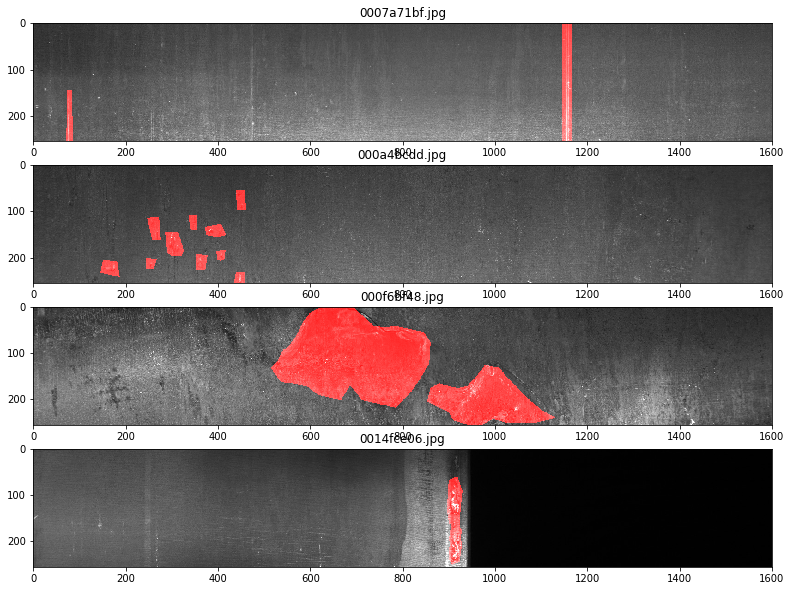

In [34]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread(os.path.join(path, 'train_images/', fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask2(
        df_train['EncodedPixels'].iloc[i], (256, 1600)
      )
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Create train Dataset and DataLoader

In [0]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        n = self.df['ImageId_ClassId'].iloc[index].split('_')                     
        fn = n[0]
        label = int(n[1]) - 1         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(
                self.df['EncodedPixels'].iloc[index], 
                (256, 1600),
                label,
                n_classes
              )
            mask = transforms.ToPILImage()(mask)         
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img       

In [0]:
data_transf = transforms.Compose(
    [
     transforms.Resize((256, 256)),
     transforms.ToTensor()
    ]
)

train_indx = int(len(df_train) * train_data_percent)
df_tr = df_train[0: train_indx]

eval_indx = int(len(df_train) * eval_data_percent) + train_indx
df_eval = df_train[train_indx: eval_indx]

df_test = df_train[eval_indx:]

train_data = ImageData(df = df_tr, transform = data_transf)
train_loader = DataLoader(
    dataset = train_data, batch_size=batch_size, shuffle=True
  )

eval_data = ImageData(df = df_eval, transform = data_transf)
eval_loader = DataLoader(dataset = eval_data)

test_data = ImageData(df = df_test, transform = data_transf)
test_data = DataLoader(dataset = test_data)

### Show some image and mask

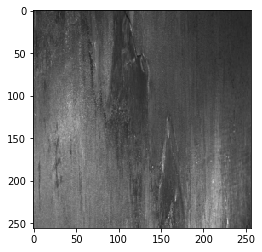

In [37]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

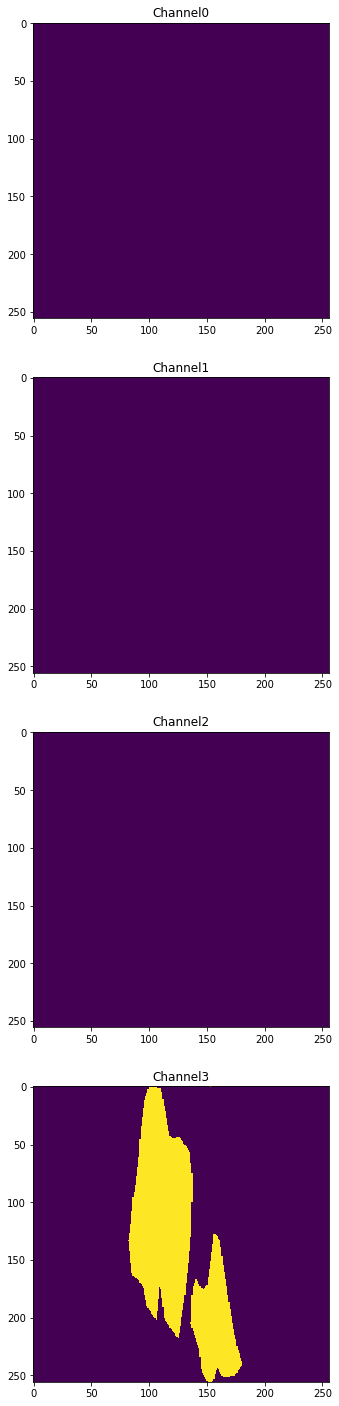

In [38]:
columns = 1
rows = n_classes
img = train_data[3][1].permute(1, 2, 0)
fig = plt.figure(figsize=(25,25))
for i in range(n_classes):
    fig.add_subplot(
        rows, columns, i+1).set_title("Channel{}".format(i)
    )
    plt.imshow(img[:, :, i])
plt.show()

### Models

UNet:

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load(os.path.join(
            path, "resnet18/resnet18.pth"))
        )
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True
            )

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

Simple CNN, from UNet:

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class BaseModel(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.layer1 = convrelu(3, 256, 3, 1)
        self.layer2 = convrelu(256, 128, 3, 1)
        self.layer3 = convrelu(128, 64, 3, 1)
        self.layer_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x = self.layer1(input)
        x = self.layer2(x)
        x = self.layer3(x)
        out = self.layer_last(x)
        return out

### Train Preparation

In [41]:
#model = UNet(n_class=4).cuda()
model = BaseModel(n_class=4).cuda()
if reload_last_model and os.path.exists(model_save_path):
  print("Loading model from {}".format(model_save_path))
  model.load_state_dict(torch.load(model_save_path))
else:
  print("Not load model, train from scrath")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(), weight_decay=weight_decay, lr = lr
)

Not load model, train from scrath


### Define Functions for training eval and test

Get LR value if we use lr decay

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Eval Matrics:

In [0]:
def dice_coefficient(x, y):
  """
  :param X: numpy array
  :param y: numpy array
  :return: float, dice coefficient for one x, y pair
  x, y is mask the preidiction values (mask)
  """
  x = x.reshape(-1, 1)
  y = y.reshape(-1, 1)
  #print(sum(((x*y) > 0)))
  #print(sum((x+y) > 0))
  return 2 * sum(((x*y) > 0)) / (x.size + y.size)

def iou(x, y):
  x = x.reshape(-1, 1)
  y = y.reshape(-1, 1)
  #print(sum(((x*y) > 0)))
  #print(sum((x+y) > 0))
  return sum(((x*y) > 0)) / sum((x + y) > 0)


Inference:

In [0]:
def predict(model, data_loader, resize=False, out_mask=True):
    predict = []
    Y = []
    model.eval()
    print("Predicting...")
    total = 0
    with tqdm_notebook(total=len(data_loader.dataset), leave=True) as pbar:
      for data, y in data_loader:
        data = data.cuda()
        output = model(data)  
        output = output.cpu().detach().numpy() * (-1)
        predict.append(abs(output[0]))
        Y.append(y.numpy().squeeze(axis=0))
        pbar.update(len(data))
    
    pred_rle = []
    print("Converting Image...")
    with tqdm_notebook(total=len(predict), leave=True) as pbar:
      for p in predict:        
          img = np.copy(p)
          mn = np.mean(img)*1.2
          img[img<=mn] = 0
          img[img>mn] = 1
          if resize:
            img = cv2.resize(img[0], (1600, 256))
          if not out_mask:
            img = mask2rle(img)
          pred_rle.append(img)
          pbar.update(1)
    predict = pred_rle
    return predict, Y


Eval Data:

In [0]:
def eval_data_set(model, data_loader, matrics):
  images = []
  defect_type = []
  corr = []
  predictions, Y = predict(model, data_loader)
  for i, pred in enumerate(predictions):
    corr.append(matrics(pred, Y[i]))
    img = cv2.cvtColor(
        data_loader.dataset[i][0].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB
      )
    cls = np.argmax(np.sum(pred, axis=(1,2)), axis=0)
    cls = int(cls)
    mask = pred[cls, :, :]
    img[mask==1,0] = 255
    img = torch.tensor(img).permute(2, 1, 0)
    images.append(img)
    defect_type.append(cls)
  return np.mean(corr), images, defect_type

Launch Tensorbaord:

In [0]:
if clear_tensor_board_history:
  shutil.rmtree("/content/runs", ignore_errors=True)
  os.mkdir("/content/runs")

In [47]:
%load_ext tensorboard
%tensorboard --logdir=/content/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 462), started 0:24:23 ago. (Use '!kill 462' to kill it.)

### Training

In [48]:
summary_writter = SummaryWriter() # in ./run by default
total_it = 0
last_result = 0
for epoch in range(total_epochs):      
  model.train()
  with tqdm_notebook(total=len(train_loader.dataset)) as pbar:   
    for it, (data, target) in enumerate(train_loader):                         
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        data_len = len(data)
        pbar.update(len(data))
        pbar.set_postfix(epoch=epoch, loss=loss.item())
        total_it += data_len
        summary_writter.add_scalar("Loss/train", loss.item(), total_it)
        summary_writter.add_scalar("LR/train", get_lr(optimizer), total_it)
        summary_writter.flush()
    # eval after each epoch
    corr, images, c = eval_data_set(model, eval_loader, dice_coefficient)
    summary_writter.add_scalar("MDC/evaluation", corr, total_it)
    for i, img in enumerate(images[:10]):
      print(img.shape)
      summary_writter.add_image(str(c[i]), img, epoch)
    print("Result = {}".format(corr))
    if corr > last_result:
      print("Saving Model...")
      torch.save(model.state_dict(), model_save_path)
      last_result = result
    summary_writter.flush()
summary_writter.close()

SyntaxError: ignored

### Show prediction on image from train dataset

In [0]:
plt.imshow(train_data[6][0].permute(1, 2, 0))

In [0]:
x = train_data[6][0].unsqueeze(0)
o = model(x.cuda())  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

### Read submit file

In [0]:
submit_test_df = pd.read_csv(path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '})

### Create test Dataset and DataLoader

In [0]:
submit_test_data = ImageData(df = submit_test_df, transform = data_transf, subset="test")
submit_test_loader = DataLoader(dataset = submit_test_data, shuffle=False)

### Prepare submission file

In [0]:
submit['EncodedPixels'][submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')] = pred_rle
submit.head()

In [0]:
img_s = cv2.imread( path + 'test_images/'+ submit['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

In [0]:
mask_s = rle2mask(submit['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)

In [0]:
submit.head(10)

In [0]:
submit.to_csv('submission.csv', index=False)